In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/pre/data.csv")

In [ ]:
data

## Split and normalize the data

In [ ]:
#Split the data in 70% training, 20% validation and 10% testing
from sklearn.model_selection import train_test_split

# Find the pixel ID indices for splitting
pixel_ids = data['Pixel_ID'].unique()
split_idx_1 = int(0.7 * len(pixel_ids))
split_idx_2 = int(0.9 * len(pixel_ids))
train_pixel_ids = pixel_ids[:split_idx_1]
val_pixel_ids = pixel_ids[split_idx_1:split_idx_2]
test_pixel_ids = pixel_ids[split_idx_2:]

# Split the data based on the pixel ID ranges
train = data.loc[data['Pixel_ID'].isin(train_pixel_ids)]
val = data.loc[data['Pixel_ID'].isin(val_pixel_ids)]
test = data.loc[data['Pixel_ID'].isin(test_pixel_ids)]

In [ ]:
#Normalization - RobustScaler
from sklearn.preprocessing import RobustScaler

#training data
# create a copy of the merged table with only the relevant columns
ndvi_rain_temp = train[['NDVI', 'Rainfall', 'Temperature']].copy()
# scale the data using RobustScaler
scaler = RobustScaler()
ndvi_rain_temp_scaled = scaler.fit_transform(ndvi_rain_temp)
# create a new DataFrame with the scaled data
ndvi_rain_temp_scaled_df = pd.DataFrame(ndvi_rain_temp_scaled, columns=['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_rain_temp.index)
# merge the scaled data with the original merged table
train_scaled = pd.concat([train, ndvi_rain_temp_scaled_df], axis=1)

#validation data
# create a copy of the merged table with only the relevant columns
ndvi_rain_temp = val[['NDVI', 'Rainfall', 'Temperature']].copy()
# scale the data using RobustScaler
scaler = RobustScaler()
ndvi_rain_temp_scaled = scaler.fit_transform(ndvi_rain_temp)
# create a new DataFrame with the scaled data
ndvi_rain_temp_scaled_df = pd.DataFrame(ndvi_rain_temp_scaled, columns=['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_rain_temp.index)
# merge the scaled data with the original merged table
val_scaled = pd.concat([val, ndvi_rain_temp_scaled_df], axis=1)

#testing data
# create a copy of the merged table with only the relevant columns
ndvi_rain_temp = test[['NDVI', 'Rainfall', 'Temperature']].copy()
# scale the data using RobustScaler
scaler = RobustScaler()
ndvi_rain_temp_scaled = scaler.fit_transform(ndvi_rain_temp)
# create a new DataFrame with the scaled data
ndvi_rain_temp_scaled_df = pd.DataFrame(ndvi_rain_temp_scaled, columns=['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled'], index=ndvi_rain_temp.index)
# merge the scaled data with the original merged table
test_scaled = pd.concat([test, ndvi_rain_temp_scaled_df], axis=1)

In [ ]:
test_scaled.head(30)

In [ ]:
# Get statistics for the NDVI column
ndvi_stats = train_scaled['NDVI_scaled'].describe()

# Print the statistics
print(ndvi_stats)

count    141960.000000
mean          0.065518
std           0.617337
min          -4.094080
25%          -0.449975
50%           0.000000
75%           0.550025
max           1.710354
Name: NDVI_scaled, dtype: float64


In [ ]:
# Check for NaN values in the scaled input features
has_nan = train_scaled.isna().any().any()
print("NaN values in the scaled input features:", has_nan)

NaN values in the scaled input features: False


## Build data structure for train the model

In [ ]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1,l2
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K


In [ ]:
# Select input and output variables
input_vars = ['NDVI_scaled', 'Rainfall_scaled', 'Temperature_scaled']
output_var = 'NDVI_scaled'

# Define window size for input sequences
window_size = 20

In [ ]:
# Create sequences of input and output for training data
X_train = []
y_train = []
for pixel_id in train_scaled['Pixel_ID'].unique():
    pixel_data = train_scaled[train_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_train.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_train.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for validation data
X_val = []
y_val = []
for pixel_id in val_scaled['Pixel_ID'].unique():
    pixel_data = val_scaled[val_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_val.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_val.append(pixel_data.loc[i, output_var])

# Create sequences of input and output for testing data
X_test = []
y_test = []
for pixel_id in test_scaled['Pixel_ID'].unique():
    pixel_data = test_scaled[test_scaled['Pixel_ID'] == pixel_id].reset_index(drop=True)
    for i in range(window_size, pixel_data.shape[0]):
        X_test.append(pixel_data.loc[i-window_size:i-1, input_vars].values)
        y_test.append(pixel_data.loc[i, output_var])

# Convert X and y to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


In [ ]:
df_X_test = pd.DataFrame(X_test.reshape(X_test.shape[0], -1))
df_y_test = pd.DataFrame(y_test.reshape(y_test.shape[0], -1))
df_y_test

In [ ]:
y_test.shape

(23820,)

### 1. LSTM mdoel

In [ ]:
# Define the LSTM model architecture

lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(window_size, len(input_vars))))
lstm_model.add(Dense(1))
lstm_model.compile(loss="MSE", optimizer= 'adam')
# Set up early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Train the LSTM model
lstm_history = lstm_model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val),callbacks=[early_stop])

212/212 [==============================] - 0s 2ms/step
R2 score (train): 0.888725781833409
R2 score (validation): 0.6995382014535878


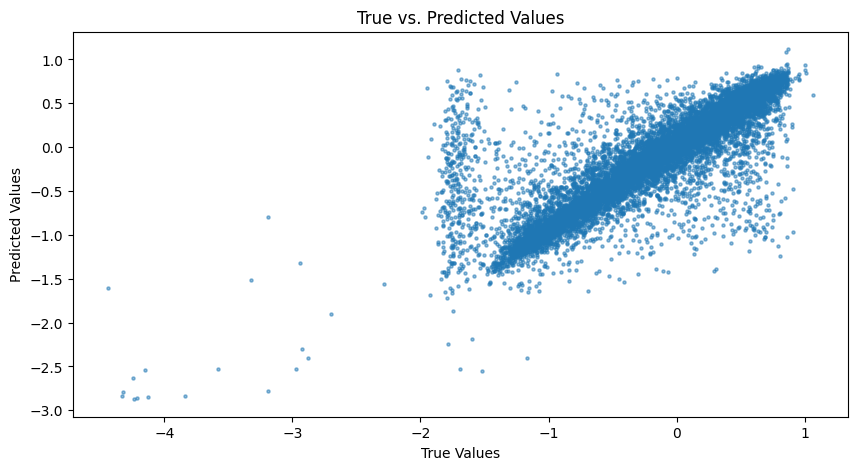

In [ ]:
from sklearn.metrics import r2_score
# Evaluate the model
y_pred_train = lstm_model.predict(X_train)
y_pred_val = lstm_model.predict(X_val)
y_pred_test = lstm_model.predict(X_test)

r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

print("R2 score (train):", r2_train)
print("R2 score (validation):", r2_val)

# Plot the true values vs. predicted values
plt.figure(figsize=(10, 5))
plt.scatter(y_val, y_pred_val, s=5, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs. Predicted Values')
plt.show()

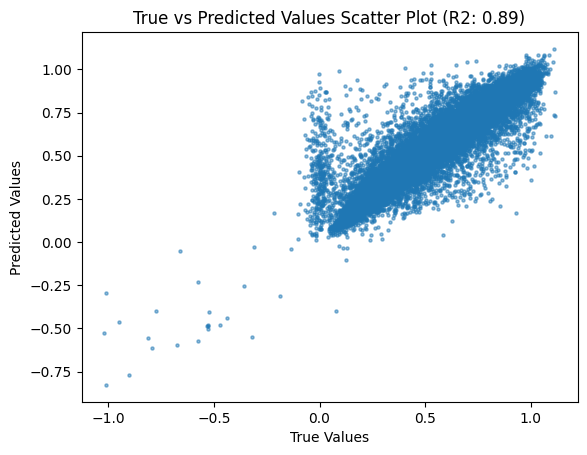

In [ ]:
#Convert the NDVI value to the ordinary
target_scaler = RobustScaler()
y_scaled = target_scaler.fit_transform(data[['NDVI']])

y_pred_train_ = target_scaler.inverse_transform(y_pred_train.reshape(-1, 1)).ravel()
y_train_ = target_scaler.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_pred_val_ = target_scaler.inverse_transform(y_pred_val.reshape(-1, 1)).ravel()
y_val_ = target_scaler.inverse_transform(y_val.reshape(-1, 1)).ravel()
y_pred_test_ = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).ravel()
y_test_ = target_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()

r2 = r2_score(y_train_, y_pred_train_)
plt.scatter(y_train_, y_pred_train_,s=5, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True vs Predicted Values Scatter Plot (R2: {r2:.2f})')
plt.show()

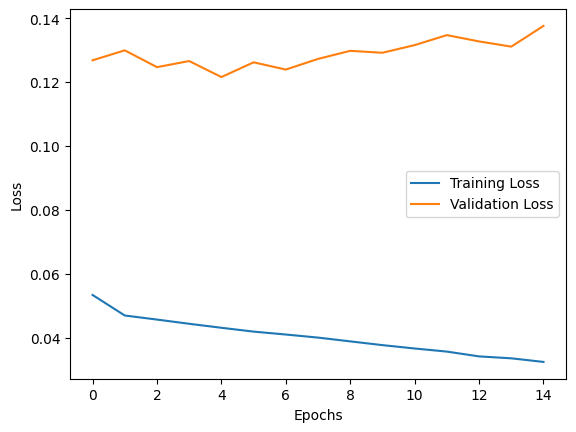

212/212 [==============================] - 0s 2ms/step


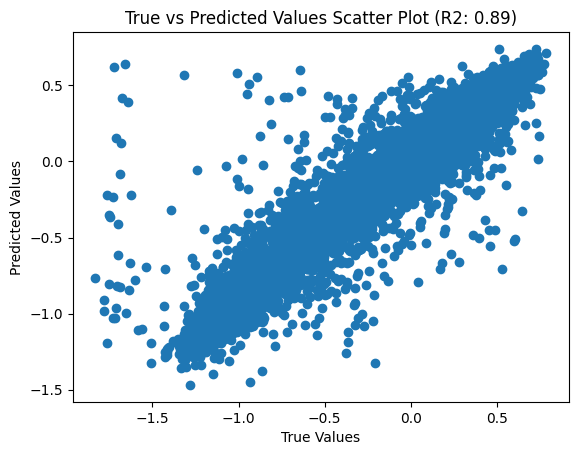

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

# Plot training and validation loss
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Create a scatter plot of true vs predicted values
lstm_predictions = lstm_model.predict(X_test)

r2 = r2_score(y_test, lstm_predictions)
plt.scatter(y_test, lstm_predictions)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'True vs Predicted Values Scatter Plot (R2: {r2:.2f})')
plt.show()


### Random forest model

In [ ]:
# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train.reshape((X_train.shape[0], -1)), y_train)

RandomForestRegressor(random_state=42)

In [ ]:
# Evaluate the Random Forest model on the test set
rf_mse = mean_squared_error(y_test, rf_model.predict(X_test.reshape((X_test.shape[0], -1))))
print("Random Forest Mean Squared Error:", rf_mse)

Random Forest Mean Squared Error: 0.045192175712142534


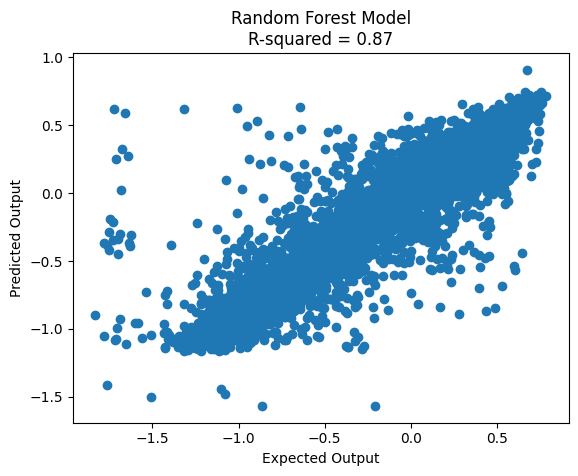

In [ ]:

# Make predictions on the test set using the Random Forest model
rf_predictions = rf_model.predict(X_test.reshape((X_test.shape[0], -1)))

# Calculate the R-squared score
r2 = r2_score(y_test, rf_predictions)

# Create a scatter plot comparing predicted and expected output values
plt.scatter(y_test, rf_predictions)
plt.xlabel('Expected Output')
plt.ylabel('Predicted Output')
plt.title(f'Random Forest Model\nR-squared = {r2:.2f}')
plt.show()


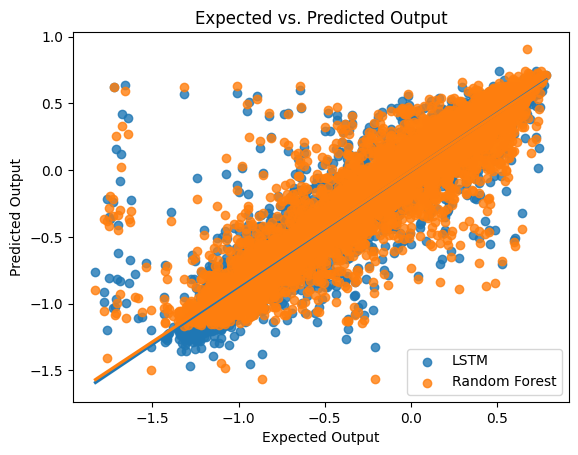

In [ ]:
import seaborn as sns
# Create a scatter plot with regression lines comparing predicted and expected output values
sns.regplot(x=y_test, y=lstm_predictions, label='LSTM')
sns.regplot(x=y_test, y=rf_predictions, label='Random Forest')
plt.xlabel('Expected Output')
plt.ylabel('Predicted Output')
plt.title('Expected vs. Predicted Output')
plt.legend()
plt.show()

Both LSTM and RF model scatter plots shpw that the points are mainly concentrated in the right upper corner, it suggests that the model is performing well for larger values, but not as well for smaller values.Small MSE suggests that the model is making accurate predictions on average. And the R^2 is relative low, means model can only explain around half of the variability in the data.

## Compare the model performance

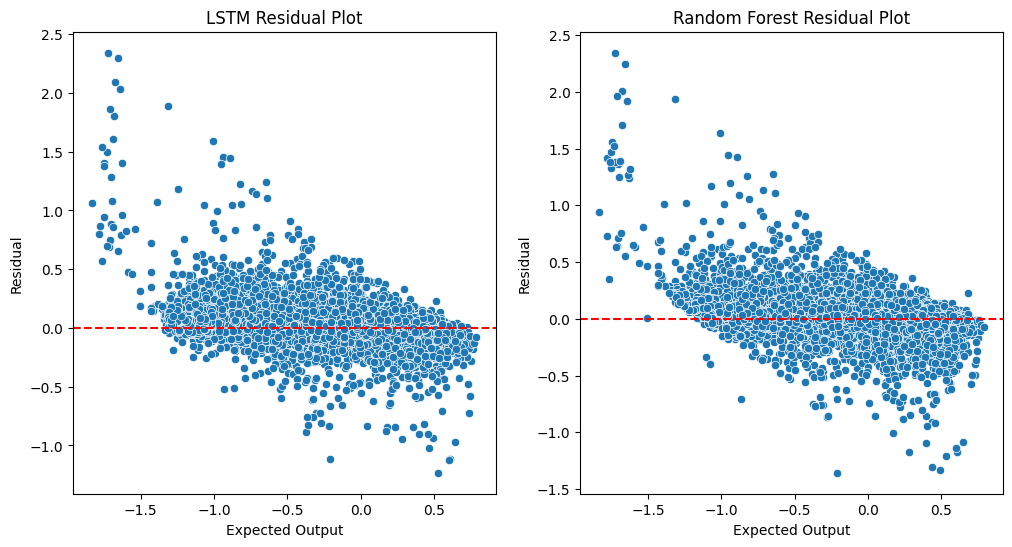

In [ ]:
# Make predictions on the test data for both models

# Create residual plots comparing predicted and expected output values for both models
lstm_residuals = lstm_predictions - y_test
rf_residuals = rf_predictions - y_test

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Plot residual plot for LSTM model
sns.scatterplot(x=y_test, y=lstm_residuals, ax=ax1)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Expected Output')
ax1.set_ylabel('Residual')
ax1.set_title('LSTM Residual Plot')

# Plot residual plot for Random Forest model
sns.scatterplot(x=y_test, y=rf_residuals, ax=ax2)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Expected Output')
ax2.set_ylabel('Residual')
ax2.set_title('Random Forest Residual Plot')

plt.show()


423/423 [==============================] - 1s 2ms/step


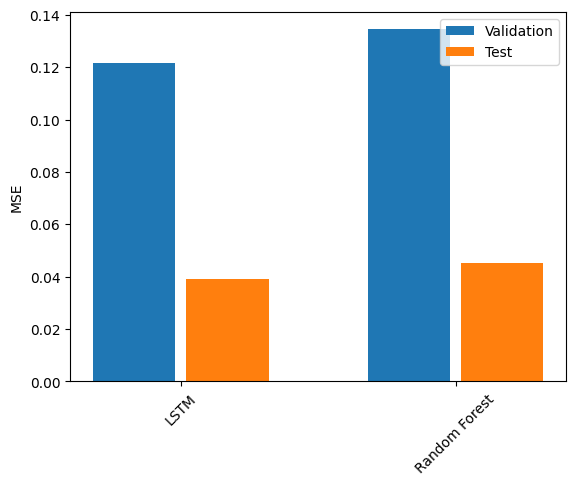

In [ ]:
# Compare the Mean Squared Error (MSE) for each model
from sklearn.metrics import mean_squared_error

lstm_val_predictions = lstm_model.predict(X_val)
X_val_2d = X_val.reshape(X_val.shape[0], -1)
rf_val_predictions = rf_model.predict(X_val_2d)

# Calculate MSE for each model on validation set
lstm_val_mse = mean_squared_error(y_val, lstm_val_predictions)
rf_val_mse = mean_squared_error(y_val, rf_val_predictions)

# Calculate MSE for each model on test set
lstm_test_mse = mean_squared_error(y_test, lstm_predictions)
rf_test_mse = mean_squared_error(y_test, rf_predictions)

# Plot bar chart
x = np.arange(2)
width = 0.3

val_mse = [lstm_val_mse, rf_val_mse]
test_mse = [lstm_test_mse, rf_test_mse]

plt.bar(x - 0.17, val_mse, width, label='Validation')
plt.bar(x + 0.17, test_mse, width, label='Test')
plt.xticks(ticks=x, labels=['LSTM', 'Random Forest'],
           rotation=45)
plt.ylabel('MSE')
_ = plt.legend()


## View the single and multiple steps prediction performance

1/1 [==============================] - 0s 31ms/step


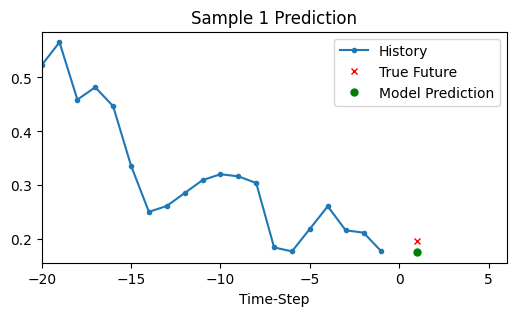

1/1 [==============================] - 0s 61ms/step


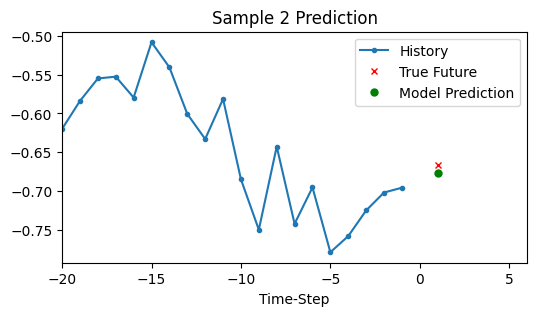

1/1 [==============================] - 0s 24ms/step


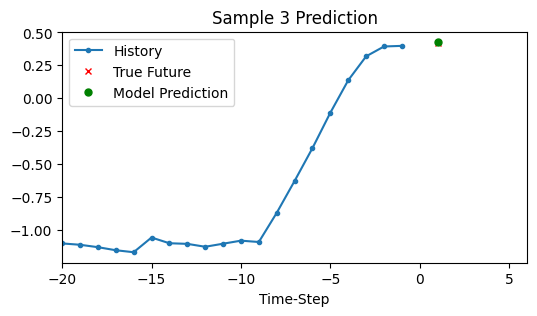

1/1 [==============================] - 0s 24ms/step


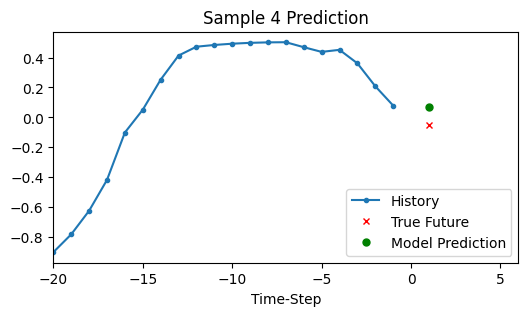

1/1 [==============================] - 0s 26ms/step


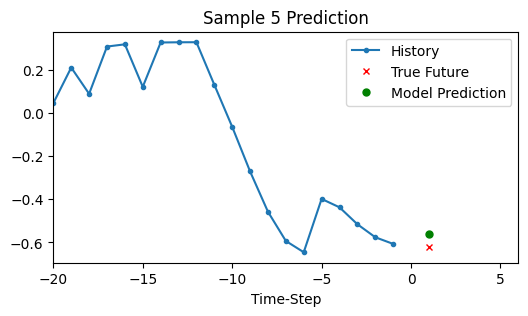

In [ ]:
# LSTM

# single step prediction
def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = 1

    fig, ax = plt.subplots(figsize=(6, 3))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 2) * 2])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 5  # number of samples to visualize
random_indices = np.random.choice(len(X_test), n, replace=False)

for i, idx in enumerate(random_indices):
    x_sample = X_test[idx]
    y_sample = y_test[idx]
    y_pred = lstm_model.predict(x_sample[np.newaxis, :, :])[0]

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_pred

    show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")


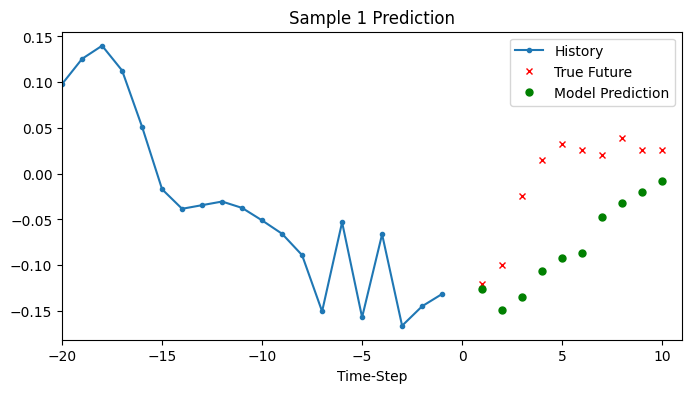

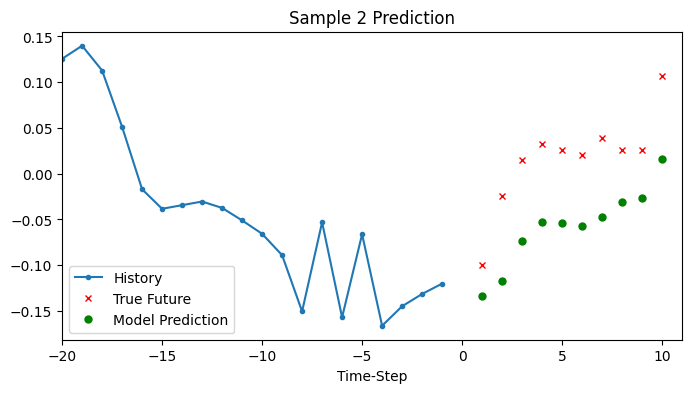

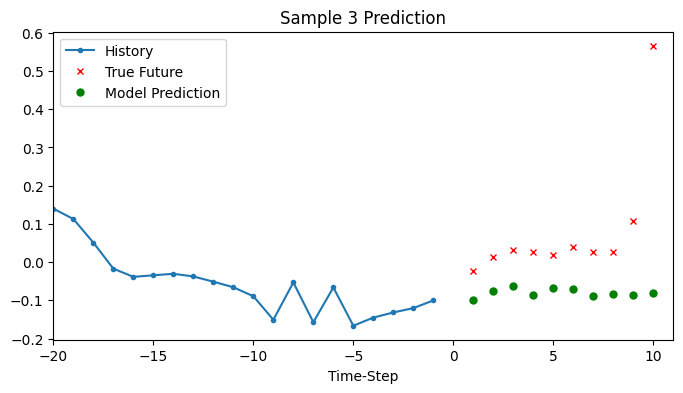

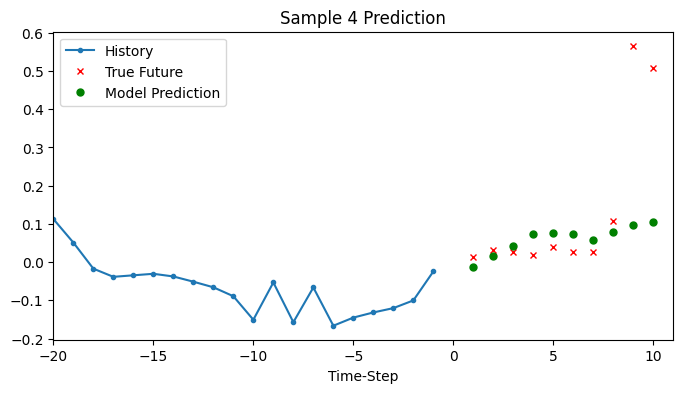

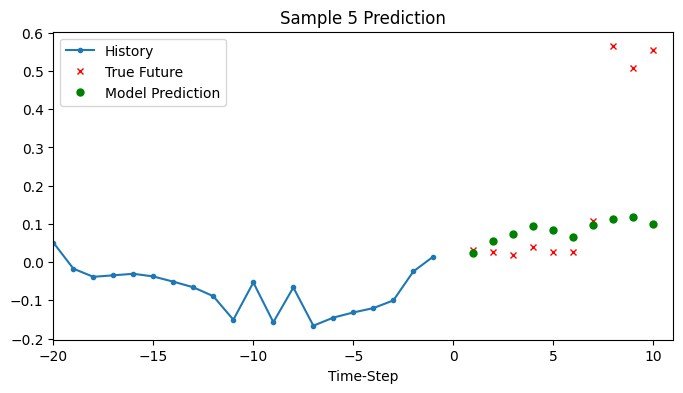

In [ ]:
# RF model - first 10 timesteps 

def predict_next_steps(model, input_sequence, num_steps):
    predictions = []
    current_input = input_sequence.copy()
    for _ in range(num_steps):
        current_input_reshaped = current_input.reshape(1, -1)
        prediction = model.predict(current_input_reshaped)[0]
        predictions.append(prediction)
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction
    return np.array(predictions)

def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = np.arange(1, plot_data[1].shape[0] + 1)

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], future[-1] + 1])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 5  # number of samples to visualize
num_future_steps = 10  # Number of future steps to predict (from 21st to 30th)
for i in range(n):
    x_sample = X_test[i]
    y_sample = y_test[i : i + num_future_steps]

    # Generate the 21st to 30th NDVI predictions
    y_preds = predict_next_steps(rf_model, x_sample, num_future_steps)

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_preds

    # Add the predicted NDVI from 21st to 30th to the plot
    show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")


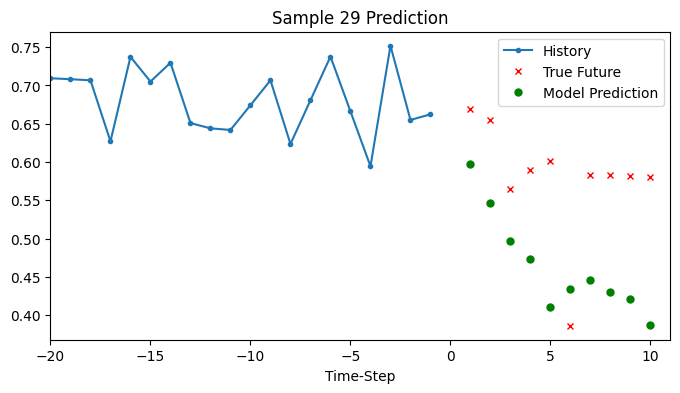

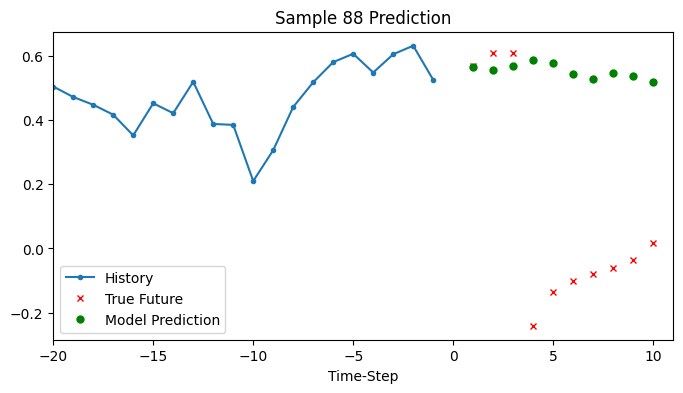

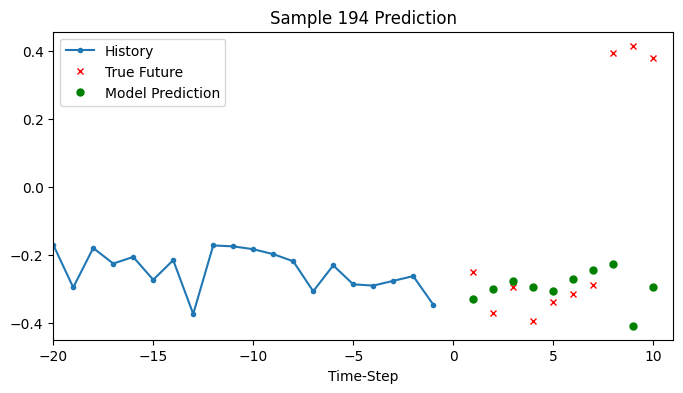

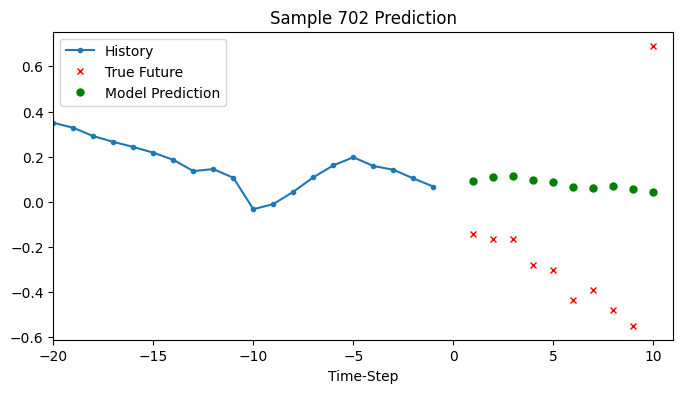

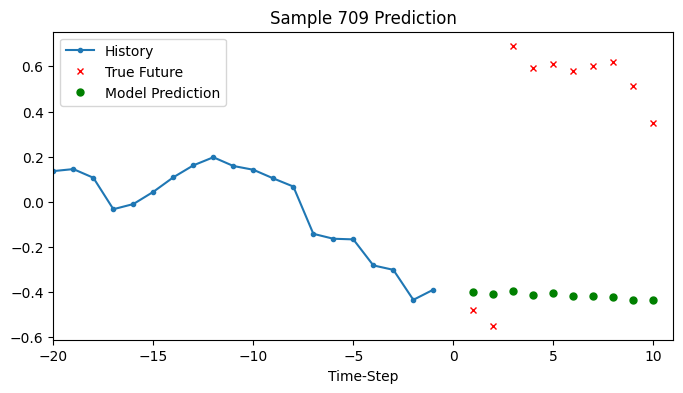

In [ ]:
# RFmodel - radomly 10 timesteps

import random

def predict_next_steps(model, input_sequence, num_steps):
    predictions = []
    current_input = input_sequence.copy()
    for _ in range(num_steps):
        current_input_reshaped = current_input.reshape(1, -1)
        prediction = model.predict(current_input_reshaped)[0]
        predictions.append(prediction)
        current_input = np.roll(current_input, -1, axis=0)
        current_input[-1, 0] = prediction
    return np.array(predictions)

def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    future = np.arange(1, plot_data[1].shape[0] + 1)

    fig, ax = plt.subplots(figsize=(8, 4))
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=5, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], future[-1] + 1])
    plt.xlabel("Time-Step")
    plt.show()

# Prepare data for the plot
n = 1000  # number of samples to train on
num_future_steps = 10  # Number of future steps to predict (from 21st to 30th)

predicted_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the predicted NDVI values for all timesteps
expected_ndvi_all = np.zeros((n, num_future_steps))  # Array to store the expected NDVI values for all timesteps

# Randomly select 5 indices from the test set for visualization
n_visualize = 5
random_indices = random.sample(range(n), n_visualize)

for i in range(n):
    x_sample = X_test[i]
    y_sample = y_test[i : i + num_future_steps]

    # Generate the 21st to 30th NDVI predictions
    y_preds = predict_next_steps(rf_model, x_sample, num_future_steps)

    # Append the predicted NDVI values to the array
    predicted_ndvi_all[i, :] = y_preds.flatten()
    expected_ndvi_all[i, :] = y_sample.flatten()

    history_ndvi = x_sample[:, 0]  # Select only NDVI_scaled from input_vars
    true_future = y_sample
    model_prediction = y_preds

    # If the current index is in the list of random indices, visualize the sample
    if i in random_indices:
        show_plot([history_ndvi, true_future, model_prediction], f"Sample {i + 1} Prediction")


In [ ]:
#Cteate 2 dataframes for the model predicted NDVI and the correlated expected NDVI value

# Convert the NumPy arrays to pandas DataFrames
df_predicted = pd.DataFrame(data=predicted_ndvi_all, columns=["NDVI_t21", "NDVI_t22", "NDVI_t23", "NDVI_t24", "NDVI_t25", "NDVI_t26", "NDVI_t27", "NDVI_t28", "NDVI_t29", "NDVI_t30"])
df_expected = pd.DataFrame(data=expected_ndvi_all, columns=["NDVI_t21", "NDVI_t22", "NDVI_t23", "NDVI_t24", "NDVI_t25", "NDVI_t26", "NDVI_t27", "NDVI_t28", "NDVI_t29", "NDVI_t30"])

# Add index labels for each sequence
df_predicted.index = [f"Sequence {i+1}" for i in range(n)]
df_expected.index = [f"Sequence {i+1}" for i in range(n)]

# View the DataFrames
df_predicted



In [ ]:
df_expected

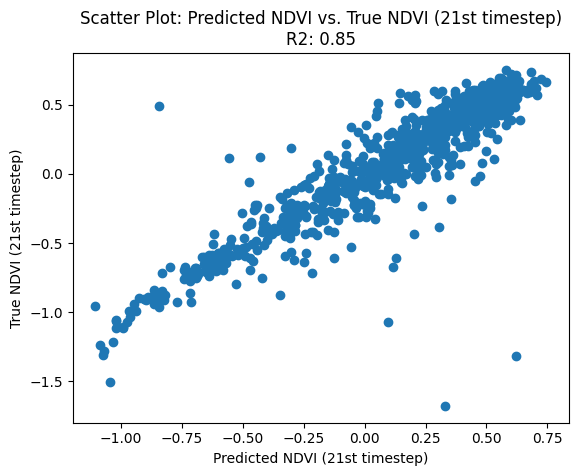

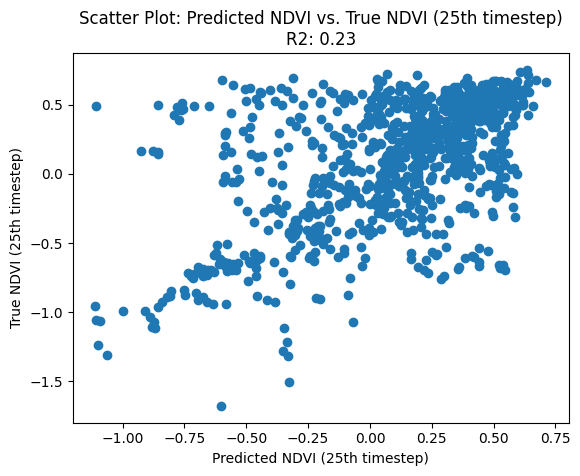

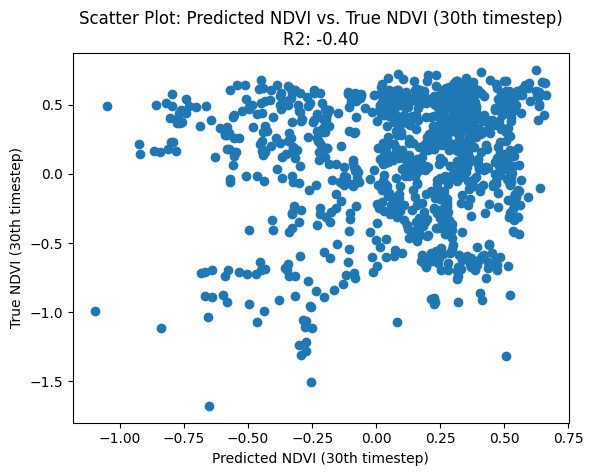

In [ ]:
# To view the correlation between predicted value and expected value in 1st, 5th and 10th timesteps

# Calculate R2 values
r2_21 = r2_score(df_expected["NDVI_t21"], df_predicted["NDVI_t21"])
r2_25 = r2_score(df_expected["NDVI_t25"], df_predicted["NDVI_t25"])
r2_30 = r2_score(df_expected["NDVI_t30"], df_predicted["NDVI_t30"])

# Plot scatter plot for timestep 21st
plt.scatter(df_predicted["NDVI_t21"], df_expected["NDVI_t21"])
plt.xlabel("Predicted NDVI (21st timestep)")
plt.ylabel("True NDVI (21st timestep)")
plt.title("Scatter Plot: Predicted NDVI vs. True NDVI (21st timestep)\nR2: {:.2f}".format(r2_21))
plt.show()

# Plot scatter plot for timestep 25th
plt.scatter(df_predicted["NDVI_t25"], df_expected["NDVI_t25"])
plt.xlabel("Predicted NDVI (25th timestep)")
plt.ylabel("True NDVI (25th timestep)")
plt.title("Scatter Plot: Predicted NDVI vs. True NDVI (25th timestep)\nR2: {:.2f}".format(r2_25))
plt.show()

# Plot scatter plot for timestep 30th
plt.scatter(df_predicted["NDVI_t30"], df_expected["NDVI_t30"])
plt.xlabel("Predicted NDVI (30th timestep)")
plt.ylabel("True NDVI (30th timestep)")
plt.title("Scatter Plot: Predicted NDVI vs. True NDVI (30th timestep)\nR2: {:.2f}".format(r2_30))
plt.show()


## Other models - LTC

In [ ]:
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_test: (15280, 20, 3)
Shape of y_test: (15280,)


In [ ]:
!pip install seaborn ncps

In [ ]:
from tensorflow import keras
from ncps import wirings
from ncps.tf import LTC
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras.models import Model
import seaborn as sns

In [ ]:
ncp_arch = wirings.AutoNCP(8,1)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 3)),
        LTC(ncp_arch, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ltc_1 (LTC)                 (None, None, 1)           132       
                                                                 
Total params: 132
Trainable params: 132
Non-trainable params: 0
_________________________________________________________________


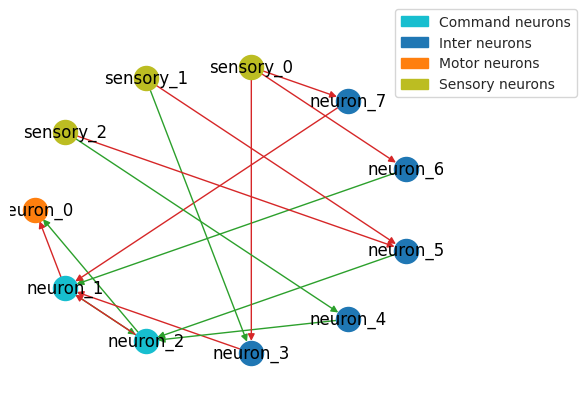

In [ ]:

# Define the number of input features
num_input_features = len(input_vars)

ncp_arch = wirings.AutoNCP(8, 1)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, num_input_features)),
        LTC(ncp_arch, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ncp_arch.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [ ]:
# Set up early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ncp_history = ncp_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stop])


In [ ]:
#Evaluate the NCP model using test set
y_pred = ncp_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


478/478 [==============================] - 1s 2ms/step
Mean Squared Error: 0.65890732102393


In [ ]:
# convLSTM

# Define the model architecture

model = Sequential()
model.add(ConvLSTM2D(filters=32, kernel_size=(3,3), input_shape=(window_size, 1, 1, len(input_vars)), padding='same', return_sequences=True))
model.add(Dropout(0.2))
model.add(ConvLSTM2D(filters=16, kernel_size=(3,3), padding='same', return_sequences=False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')